## Классификация новостей (Для КТ по TF Serving)
https://ithub.bulgakov.app/lessons/57488

## Подключение библиотек

In [ ]:
from google.colab import files # Для работы с файлами
import numpy as np # Для работы с данными 
import matplotlib.pyplot as plt # Для вывода графиков
import os # Для работы с файлами
%matplotlib inline

import tensorflow as tf
from tensorflow.keras import utils # Для работы с категориальными данными
from tensorflow.keras.models import Sequential # Полносвязная модель
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Flatten, Activation # Слои для сети
from tensorflow.keras.preprocessing.text import Tokenizer # Методы для работы с текстами
from tensorflow.keras.preprocessing.sequence import pad_sequences # Метод для работы с последовательностями

from google.colab import drive # Для работы с Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Удаляем директорию с распакованными данными (если есть)
!rm -rf /content/cp5_news

In [ ]:
!unzip -q '/content/drive/MyDrive/Colab Notebooks/Handling_Data/CheckPoint_TF_Serving/2_Task_files/cp5_news.zip' -d /content/

### Загрузка текстов из обучающей и тренировочной выборок

In [ ]:
# Функция для загрузки файла
def loadText(fileName):
  f = open(fileName, 'r') # Открываем файл в режиме чтения
  text = f.read()         # Читаем текст
  text = text.replace("\n", " ") # Заменяем переносы строк на пробелы
  text = text.replace("\r", " ") # Заменяем переносы строк на пробелы
  text = text.replace("\t", " ") # Заменяем табуляции на пробелы
  f.close()
  
  return text

labels = ["Politics", "Sport", "Tech"] # Классифицируемые новости
labelsNum = len(labels) # Количество классифицируемых групп

In [ ]:
trainText = [] # Обучающие тексты
validationText = [] # Проверочные тексты
testText = []  # Тестовые тексты

fileList = os.listdir('cp5_news/') # Получаем список всех файлов
print(fileList)
for label in labels:
  for file in fileList:
    if label in file: # Проверяем, содержит ли файл j в названии имя класса i
      if 'train' in file: # Если в имени найденного класса есть строка "train" 
        trainText.append(loadText('cp5_news/' + file)) #добавляем в обучающую выборку
        print(file, 'добавлен в обучающую выборку')
      if 'test' in file: # Если в имени найденного класса есть строка "test"
        testText.append(loadText('cp5_news/' + file)) # Добавляем в обучающую выборку
        print(file, 'добавлен в тестовую выборку')
      if 'validation' in file:
        validationText.append(loadText('cp5_news/' + file))
        print(file, 'добавлен в проверочную выборку')

['Sport test.txt', 'Tech train.txt', 'Politics test.txt', 'Politics validation.txt', 'Politics train.txt', 'Tech validation.txt', 'Sport train.txt', 'Sport validation.txt', 'Tech test.txt']
Politics test.txt добавлен в тестовую выборку
Politics validation.txt добавлен в проверочную выборку
Politics train.txt добавлен в обучающую выборку
Sport test.txt добавлен в тестовую выборку
Sport train.txt добавлен в обучающую выборку
Sport validation.txt добавлен в проверочную выборку
Tech train.txt добавлен в обучающую выборку
Tech validation.txt добавлен в проверочную выборку
Tech test.txt добавлен в тестовую выборку


In [ ]:
print("Количество загруженных тренировочных текстов:", len(trainText))
print("Количество загруженных тестовых текстов:", len(testText))
print("Количество загруженных проверочных текстов:", len(validationText))

Количество загруженных тренировочных текстов: 3
Количество загруженных тестовых текстов: 3
Количество загруженных проверочных текстов: 3


In [ ]:
# Примеры содержимого в тренировочных текстах
print(trainText[0][:100])
print(trainText[1][:100])
print(trainText[2][:100])

print("\n")

# Примеры содержимого в проверочных текстах
print(testText[0][:100])
print(testText[1][:100])
print(testText[2][:100])

   политика Россия Украина Сирия Европа США аналитика война Путин  В правительстве Украины заявили о
   Делимся впечатлениями от игры сборной  Матыцин назвал суммы премиальных, которые получат наши мед
 Софт и игры Обзор Part Time UFO: подработка инопланетянином от создателей Kirby   Битва ассистентов


﻿  политика Россия Украина Сирия Европа США аналитика война Путин  Цитату Байдена о "великом негре" 
 Ловите состав сборной на октябрьские матчи отбора ЧМ-2022.  Кто лишний? Кого не хватает? Сергей Пло
  Новинка, сочетающая в себе огромную батарею на 6000 мАч, камеру на 64 Мп и современный дизайн за в


### Токенизация текстов

In [ ]:
numWords = 20000 # Количество слов/индексов, которое мы будем учитывать при обучении
# индекс - частота, с которой встречается слово

# Tokenizer - встроенная в Keras функция для разбиения текста и превращения
# слов в числовые значения (индексы) с учётом частотности

# num_words - максимальное количество слов/индексов, учитываемое при составлении словаря
# filters - список ненужных символов, которые будут удалены из текстов
# lower - приведение слов к нижнему регистру
# split - разделитель между словами
# oov_token - на какое слово будем заменять слова, которые выше по частоте, чем numWords
# char_level - просим токенайзер не удалять однобуквенные слова

tokenizer = Tokenizer(num_words=numWords,
                      filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff',
                      lower=True,
                      split=' ',
                      oov_token='unknown',
                      char_level=False)

tokenizer.fit_on_texts(trainText) # Cоберем словарь частотности
items = list(tokenizer.word_index.items()) # Получаем индексы слов

### Сохранение обученного Токенизатора

In [ ]:
import json

In [ ]:
# Save the tokenizer to a file 
tokenizer_json = tokenizer.to_json()
with open('/content/drive/MyDrive/Colab Notebooks/Handling_Data/CheckPoint_TF_Serving/2_Task_files/tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))

In [ ]:
print("Самые часто встречающиеся слова:")
print(items[:10])
print()
print("Самые редко встречающиеся слова:")
print(items[-10:])
print()
print("Размер словаря:", len(items))

Самые часто встречающиеся слова:
[('unknown', 1), ('в', 2), ('и', 3), ('на', 4), ('с', 5), ('не', 6), ('что', 7), ('по', 8), ('за', 9), ('для', 10)]

Самые редко встречающиеся слова:
[('ming', 69837), ('chi', 69838), ('kuo', 69839), ('исчезут', 69840), ('начальную', 69841), ('воссоздали', 69842), ('sanktperkele', 69843), ('встроенного', 69844), ('достоверно', 69845), ('подошёл', 69846)]

Размер словаря: 69846


In [ ]:
# # Тестирование словаря
# inputWord = input("Введите слово: ")
# print("Индекс слова", inputWord, ":", tokenizer.word_index[inputWord])

Введите слово: путин
Индекс слова путин : 102


In [ ]:
# Преобразовываем тексты в последовательности индексов согласно частотному словарю
trainWordIndexes = tokenizer.texts_to_sequences(trainText)
testWordIndexes = tokenizer.texts_to_sequences(testText)
validationWordIndexes = tokenizer.texts_to_sequences(validationText)

In [ ]:
# Проверим преобразование
print("Фрагмент обучающего текста:")
print("В виде оригинального текста:              ", trainText[2][:23])
print("Он же в виде последовательности индексов: ", trainWordIndexes[0][:5], '\n')

Фрагмент обучающего текста:
В виде оригинального текста:                Софт и игры Обзор Part
Он же в виде последовательности индексов:  [143, 49, 99, 164, 136] 



In [ ]:
print("Статистика по обучающим текстам:")

symbolsTrainText = 0 # Объявляем переменную для подсчета символов в обучающих текстах
wordsTrainText = 0 # Объявляем переменную для подсчета слов в обучающих текстах

for i in range(labelsNum): # Проходим по всем классам
  print(labels[i], " "*(10-len(labels[i])), len(trainText[i]), "символов, ", len(trainWordIndexes[i]), "слов")
  symbolsTrainText += len(trainText[i]) # Считаем символы
  wordsTrainText += len(trainWordIndexes[i]) # Считаем слова 

print('----')
print("В сумме ", symbolsTrainText, " символов, ", wordsTrainText, " слов \n")
print()
print("Статистика по тестовым текстам:")

symbolsTestText = 0 # Объявляем переменную для подсчета символов в тестовых текстах
wordsTestText = 0 # Объявляем переменную для подсчета слов в тестовых текстах

for i in range(labelsNum): # Проходим по всем классам
  print(labels[i], ' '*(10-len(labels[i])), len(testText[i]), "символов, ", len(testWordIndexes[i]), "слов")
  symbolsTestText += len(testText[i]) # Считаем символы
  wordsTestText += len(testWordIndexes[i]) # Считаем слова 
print('----')
print("В сумме ", symbolsTestText, " символов, ", wordsTestText, " слов")

Статистика по обучающим текстам:
Politics    1744978 символов,  238065 слов
Sport       1808908 символов,  262022 слов
Tech        1779783 символов,  253146 слов
----
В сумме  5333669  символов,  753233  слов 


Статистика по тестовым текстам:
Politics    197551 символов,  26851 слов
Sport       169031 символов,  24435 слов
Tech        186296 символов,  26250 слов
----
В сумме  552878  символов,  77536  слов


## Функции создания выборок-векторов (Запустить перед TF Serving)

In [ ]:
# Формирование обучающей выборки по листу индексов слов
# путем разделения на короткие векторы
# wordIndexes - массив индексов
# xLen - размер окна
# step - шаг окна
def getSetFromIndexes(wordIndexes, xLen, step):
  xText = []
  wordsLen = len(wordIndexes) # Считаем количество слов
  index = 0 # Задаем начальный индекс 

  while (index + xLen <= wordsLen): # Идём по всей длине вектора индексов
    xText.append(wordIndexes[index:index+xLen]) # "Откусываем" векторы длины xLen
    index += step # Смещаеммся вперёд на step
    
  return xText


# Формирование обучающей и проверочной выборки для каждого класса
# wordIndexes - массив индексов
# xLen - размер окна
# step - шаг окна

def createSetsMultiClasses(wordIndexes, xLen, step): # Функция принимает последовательность индексов, размер окна, шаг окна
  nClasses = len(wordIndexes) # Количество классов
  classesXSamples = []        # Здесь будет список размером "кол-во классов*кол-во окон в тексте*длину окна (например, 6 по 1341*1000)"
  for wI in wordIndexes:      # Для каждого текста выборки из последовательности индексов
    classesXSamples.append(getSetFromIndexes(wI, xLen, step))

  # Формируем один общий xSamples
  xSamples = []
  ySamples = []
  
  for t in range(nClasses):
    xT = classesXSamples[t]
    for i in range(len(xT)): # Перебираем каждое окно определенного класса
      xSamples.append(xT[i]) # Добавляем в общий список выборки
      ySamples.append(utils.to_categorical(t, nClasses)) # Добавляем соответствующий вектор класса
  
  xSamples = np.array(xSamples)
  ySamples = np.array(ySamples)
  
  return (xSamples, ySamples)

In [ ]:
# Задаём базовые параметры 
xLen = 500 # Размер окна (количество слов в векторе)
step = 60 # Шаг разбиения текста на векторы

In [ ]:
# Формируем выборки 
xTrainId, yTrain = createSetsMultiClasses(trainWordIndexes, xLen, step)
xTestId, yTest = createSetsMultiClasses(testWordIndexes, xLen, xLen)
xValidationId, yValidation = createSetsMultiClasses(testWordIndexes, xLen, xLen)
print("Размерности тренировочного набора")
print(xTrainId.shape)
print(yTrain.shape)
print()
print("Размерности проверочного набора") #TODO:
print(xValidationId.shape)
print(yValidation.shape)
print()
print("Размерности тестового набора")
print(xTestId.shape)
print(yTest.shape)
print()


Размерности тренировочного набора
(12530, 500)
(12530, 3)

Размерности проверочного набора
(153, 500)
(153, 3)

Размерности тестового набора
(153, 500)
(153, 3)



In [ ]:
print(xTrainId[0])

[  143    49    99   164   136    24   162   145   102     2  6658   106
   878    81  3074  2061     5   390    99  1751   666     2  1266  3074
   440     5   390   342  1027   747  5887  1785   106  1232     1     2
  2205     4  1644     2  1926   477  1362     4  2005     4 10642    20
    20    43    90  1751  6659     2  1266  3074   440     5   390   147
 13353  4641    11  2767     6     1     1     1     5 15446     4   706
   147  1563     1     1  2688     8     1   350    29    65    62  2311
    28    10    95    61    43    54    82     1     4   523   120   782
   266    25   150   178  1267  4240  2557     8  2897  1785     3     1
 10643  5596   234 13354  2108     5 18063     7    49 13355  1006   924
     4   706    11  2767     4   817   274 18064 10644    44    46  2612
  6660     3     1  1051  2767     6 18065   485   612  8187     7    49
     6 18066  1006    19    65   620  1588     2   401     5     1  4439
     5   306   221    49     5    20   108  9621  2

*Здесь RAM начинает быстро расходоваться*

### Преобразование выборок-векторов в Bag of Words

In [ ]:
# Преобразовываем массив векторов в Bag of Words
xTrain = tokenizer.sequences_to_matrix(xTrainId.tolist())
xTest  = tokenizer.sequences_to_matrix(xTestId.tolist())
xValidation = tokenizer.sequences_to_matrix(xValidationId.tolist())

print("Размерность обучайющей выборки")
print(xTrain.shape)
print(xTrain[0][0:100]) # Фрагмент набора слов в виде Bag of Words

print()

print("Размерность тестовой выборки")
print(xTest.shape)
print(xTest[0][0:100]) # Фрагмент набора слов в виде Bag of Words

print()

print("Размерность проверочной выборки")
print(xValidation.shape)
print(xValidation[0][0:100]) # Фрагмент набора слов в виде Bag of Words

Размерность обучайющей выборки
(12530, 20000)
[0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0.
 1. 1. 1. 0. 1. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0.
 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 1.
 0. 0. 0. 1.]

Размерность тестовой выборки
(153, 20000)
[0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 0. 0. 1. 1.
 1. 1. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0.
 0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 1.]

Размерность проверочной выборки
(153, 20000)
[0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 0. 0. 1. 1.
 1. 1. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0.
 0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 

## Структура нейросети для классификации текстов на базе Bag Of Words

In [ ]:
# Создаём полносвязную сеть
model = Sequential()
model.add(Dense(512, input_dim=20000, activation="relu"))
model.add(Dropout(0.25))
model.add(Dense(3, activation='softmax'))

model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               10240512  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 10,242,051
Trainable params: 10,242,051
Non-trainable params: 0
_________________________________________________________________


### Обучение Нейросети

In [ ]:
# Обучаем сеть
history = model.fit(xTrain, 
                    yTrain, 
                    epochs=20,
                    batch_size=64,
                    validation_data= (xValidation, yValidation)
                    )

Epoch 1/20
196/196 [==============================] - 6s 8ms/step - loss: 0.0100 - accuracy: 0.9960 - val_loss: 4.0049e-06 - val_accuracy: 1.0000
Epoch 2/20
196/196 [==============================] - 1s 6ms/step - loss: 2.8291e-07 - accuracy: 1.0000 - val_loss: 4.1996e-06 - val_accuracy: 1.0000
Epoch 3/20
196/196 [==============================] - 1s 6ms/step - loss: 1.9210e-07 - accuracy: 1.0000 - val_loss: 4.3927e-06 - val_accuracy: 1.0000
Epoch 4/20
196/196 [==============================] - 1s 6ms/step - loss: 1.3157e-07 - accuracy: 1.0000 - val_loss: 4.5983e-06 - val_accuracy: 1.0000
Epoch 5/20
196/196 [==============================] - 1s 6ms/step - loss: 1.1001e-07 - accuracy: 1.0000 - val_loss: 4.7781e-06 - val_accuracy: 1.0000
Epoch 6/20
196/196 [==============================] - 1s 6ms/step - loss: 9.2170e-08 - accuracy: 1.0000 - val_loss: 4.9393e-06 - val_accuracy: 1.0000
Epoch 7/20
196/196 [==============================] - 1s 7ms/step - loss: 7.1297e-08 - accuracy: 1.0000 

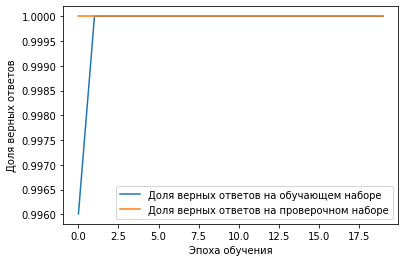

In [ ]:
# Результаты обучения
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [ ]:
# Сохранение весов модели
model.save_weights('text-news-classificator-weights.h5')

## Тест Нейросети (Инициализация НС для тестов)

In [ ]:
# Создание модели и загрузка весов в неё
model_for_test = Sequential()
model_for_test.add(Dense(512, input_dim=20000, activation="relu"))
model_for_test.add(Dropout(0.25))
model_for_test.add(Dense(3, activation='softmax'))

model_for_test.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model_for_test.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 512)               10240512  
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 10,242,051
Trainable params: 10,242,051
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_for_test.load_weights("/content/text-news-classificator-weights.h5")

### Тест на xTest выборке формата BagOfWords

In [ ]:
# Проверяем точность на тестовой выборке

rightAnswer = [0,0,0]
totalAnswer = [0,0,0]

# Получаем результаты распознавания для каждого класса
currPred = model_for_test.predict(xTest)
# Определяем номер распознанного класса для каждого вектора
currOut = np.argmax(currPred, axis=1)
# Определяем правильный класс для каждого вектора
yOut = np.argmax(yTest, axis=1)

print(currPred.shape)
print(currOut.shape)
print(yOut.shape)
print()


# Считаем сколько ответов всего и сколько из них правильных
for i in range(len(yOut)):
  predictA = currOut[i]
  rightA   = yOut[i]

  totalAnswer[rightA] += 1
  if predictA == rightA:
    rightAnswer[rightA] += 1

# Подсчитываем точность классификации
print("Точность распознавания текстов новостей")
for i in range(labelsNum):
  print("{:12s}: {:3d} из {:3d} - {:3.2f}%".format(labels[i], rightAnswer[i], totalAnswer[i], (rightAnswer[i]/totalAnswer[i]*100)))

5/5 [==============================] - 0s 4ms/step
(153, 3)
(153,)
(153,)

Точность распознавания текстов новостей
Politics    :  53 из  53 - 100.00%
Sport       :  48 из  48 - 100.00%
Tech        :  52 из  52 - 100.00%


## Формируем данные для передачи на сервер

In [ ]:
import requests
import json

Записываем модель в файл

In [ ]:
model_json = model_for_test.to_json()
json_file = open("text-news-classificator-model.json", "w")
json_file.write(model_json)
json_file.close()

Записываем веса в файл

In [ ]:
# Сохранение весов модели = СДЕЛАНО РАНЕЕ
# model.save_weights('text-news-classificator-weights.h5')

## Формируем данные для Serving

In [ ]:
model_dir = '/content/text_news_classificator_model' # имя директории, где хранятся верссии модели
version = 1  # номер версии нашей модели
export_path = model_dir+"/"+str(version) # имя директорию, куда будем выгружать модель
print('Путь для экспорта: ', export_path)

# Удаляем папку, если она у нас уже есть
if os.path.isdir(export_path):
  print('Удалили ранее созданные данные...')
  !rm -rf {export_path}

Путь для экспорта:  /content/text_news_classificator_model/1


In [ ]:
# Сохраняем модель
tf.keras.models.save_model(
    model_for_test,
    export_path,
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None
)

print('\nСохраненная модель:')
!ls -l {export_path}


Сохраненная модель:
total 92
drwxr-xr-x 2 root root  4096 Mar 21 11:44 assets
-rw-r--r-- 1 root root    55 Mar 21 11:44 fingerprint.pb
-rw-r--r-- 1 root root  7711 Mar 21 11:44 keras_metadata.pb
-rw-r--r-- 1 root root 70246 Mar 21 11:44 saved_model.pb
drwxr-xr-x 2 root root  4096 Mar 21 11:44 variables


In [ ]:
# Сливаем модель в один файл и архивируем, чтобы можно было скачать одним файлом
tar_file = "text_news_classificator_model_" + str(version) + ".tgz"

# tar - это стандартная команда Linux для объединения множества файлов в один.
# Параметр z говорит о том, что итоговый файл нужно заархивировать (используется стандартный архиватор в Linux - gzip)
!tar -zcvf {tar_file} {export_path}

# Теперь получившийся файл можно скачать и перенести на сервер

tar: Removing leading `/' from member names
/content/text_news_classificator_model/1/
/content/text_news_classificator_model/1/assets/
/content/text_news_classificator_model/1/variables/
/content/text_news_classificator_model/1/variables/variables.data-00000-of-00001
/content/text_news_classificator_model/1/variables/variables.index
/content/text_news_classificator_model/1/keras_metadata.pb
/content/text_news_classificator_model/1/saved_model.pb
/content/text_news_classificator_model/1/fingerprint.pb


## Ввод текста пользователя для отправки на сервер

In [ ]:
import requests
import json

In [ ]:
# 1) Ввести текст

# Политический текст
text = """Американское участие в конфликте между Россией и Украиной стало эпической катастрофой. 
Каждый день без мира — это еще один день, ставящий под угрозу хрупкую безопасность, 
которой мир наслаждался на протяжении десятилетий, не подвергаясь риску разрушительного воздействия ядерного оружия"""

sport_text = """Команда «Тампа-Бэй Лайтнинг» выиграла Кубок Стэнли в 2021 году, победив в финале «Монреаль Канадиенс» со счетом 4-1 в серии.
Это стало вторым Кубком Стэнли для «Тампа-Бэй Лайтнинг» в их истории, после победы в 2004 году. 
Весь сезон 2020-2021 был проведен в условиях пандемии COVID-19, и все матчи проходили без зрителей в аренах. """

# text = input()

In [ ]:
text = sport_text

### Перевод текста пользователя в Bag-of-words

In [ ]:
# Первичная обработка текста от пользователя
text = text.replace("\n", " ") # Заменяем переносы строк на пробелы
text = text.replace("\r", " ") # Заменяем переносы строк на пробелы
text = text.replace("\t", " ") # Заменяем табуляции на пробелы

# 2) Преобразовать его в формат, что использовался при обучении BagOfWords
# 2.1) Токенизация текста пользователя
with open('/content/drive/MyDrive/Colab Notebooks/Handling_Data/CheckPoint_TF_Serving/2_Task_files/tokenizer.json', 'r', encoding='utf-8') as f:
    tokenizer_json = json.load(f)
    tokenizer = tf.keras.preprocessing.text.tokenizer_from_json(tokenizer_json)
    # Проверка, что tokenizer загрузился верно:
    # items = list(tokenizer.word_index.items()) # Получаем индексы слов
    # print("Размер словаря:", len(items))
    # print("Самые часто встречающиеся слова:")
    # print(items[:10])

# 2.2) Преобразование текста в последовательности индексов согласно частотному словарю
trainWordIndexes = tokenizer.texts_to_sequences([text]) # На вход - список текстов
print(trainWordIndexes[:10])

[[307, 3272, 8513, 1, 614, 1135, 2417, 2, 135, 77, 5275, 2, 332, 5306, 1, 35, 100, 38, 20, 2, 334, 15, 384, 2183, 1, 2417, 10, 3272, 8513, 1, 2, 56, 216, 41, 507, 2, 4014, 77, 864, 774, 117, 135, 91, 1, 2, 891, 1547, 1398, 226, 3, 28, 654, 6281, 72, 1333, 2, 1]]


In [ ]:
# 2.3) Формирование выборок-векторов 

# Задаём базовые параметры (Их пришлось изменить, т.к. текст пользователя короче!)
xLen = 10 # Размер окна (количество слов в векторе)
step = 5 # Шаг разбиения текста на векторы 

xTrainId, yTrain = createSetsMultiClasses(trainWordIndexes, xLen, step)
print("Размерности текста пользователя набора")
print(xTrainId.shape)
print(yTrain.shape)

Размерности текста пользователя набора
(10, 10)
(10, 1)


In [ ]:
# Проверим преобразование 
print("Фрагмент обучающего текста:")
print("В виде оригинального текста:              ", text[:46])
print("Он же в виде последовательности индексов: ", trainWordIndexes[0][:5], '\n')

Фрагмент обучающего текста:
В виде оригинального текста:               Команда «Тампа-Бэй Лайтнинг» выиграла Кубок Ст
Он же в виде последовательности индексов:  [307, 3272, 8513, 1, 614] 



In [ ]:
# 2.3) Преобразовываем массив векторов в Bag of Words
xTrain = tokenizer.sequences_to_matrix(xTrainId.tolist())
print("Размерность обучайющей выборки")
print(xTrain.shape)
print(xTrain[0][0:100]) # Фрагмент набора слов в виде Bag of Words

Размерность обучайющей выборки
(10, 20000)
[0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


# TF Serving request НАСТРОЙКА МОЕГО СОЕДИНЕНИЯ с контейнером на сервере

In [ ]:
import requests 
import json 

In [ ]:
# Категории текстов, что предсказывает НС
labels = ["Politics", "Sport", "Tech"] # Классифицируемые новости
labelsNum = 3                          # Количество классифицируемых групп

In [ ]:
# Формируем пакет из данных для выполнение операции предсказания с помощью модели, размещенной с помощью TF Serving
pack = {
  "signature_name": "serving_default",
  "instances": xTrain.tolist()
} # tolist = Перевод всех NumPy массивов в списки для формата JSON

# Формируем данные для отправки на сервер
data = json.dumps(pack)
headers = {"content-type": "application/json"} # Заголовок требуется для корректрой обработки данных, представленных в формате json

print('Data: {} ... {}'.format(data[:50], data[len(data)-52:]))
print()

# Отправляем сформированные данные на сервер
# Указал свой ip и порт 8805 в соотв. с заданием
json_response = requests.post('http://94.198.217.236:8805/v1/models/text_news_classificator_model/versions/1:predict', data=data, headers=headers)
print("Код ответа:", json_response.status_code)
print()
predictions = json.loads(json_response.text)['predictions']

Data: {"signature_name": "serving_default", "instances": ...  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]}

Код ответа: 200



In [ ]:
predictions 

[[0.274722576, 0.44422394, 0.281053454],
 [0.286325186, 0.424182, 0.289492816],
 [0.194665834, 0.573852, 0.231482238],
 [0.20137763, 0.528486073, 0.270136207],
 [0.294379681, 0.403388262, 0.302231967],
 [0.277508348, 0.451149225, 0.271342456],
 [0.238261193, 0.477657199, 0.284081668],
 [0.273955315, 0.37210831, 0.353936285],
 [0.316212445, 0.276378721, 0.407408834],
 [0.274564326, 0.418763936, 0.306671739]]

In [ ]:
# Проверяем точность на тестовой выборке
totalAnswer = [0,0,0]

# Определяем номер распознанного класса для каждого вектора
yOut = np.argmax(predictions, axis=1) # axis = 1 => проход функции по всем строкам матрицы

In [ ]:
print(yOut) # В каком столбце максимальное значчение для каждой строки

[1 1 1 1 1 1 1 1 2 1]


In [ ]:
# Считаем сколько ответов на каждый класс
for i in range(len(yOut)):
  answer   = yOut[i]

  totalAnswer[answer] += 1

sum(totalAnswer) # 100% ответов
totalAnswer[0] # % ответов, что 1ый класс
totalAnswer[1] # % ответов, что 2ый класс
totalAnswer[2] # % ответов, что 3ый класс

# Подсчитываем точность классификации
print("Вероятности с которыми ваш текст относится к классам:")
for i in range(labelsNum):
  print("{:12s}: {:3d} из {:3d} - {:3.2f}%".format(labels[i], totalAnswer[i], sum(totalAnswer), (totalAnswer[i]/sum(totalAnswer)*100)))

Вероятности с которыми ваш текст относится к классам:
Politics    :   0 из  10 - 0.00%
Sport       :   9 из  10 - 90.00%
Tech        :   1 из  10 - 10.00%
